In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [2]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [3]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [4]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [5]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [6]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

<h3>Numerical encoding</h3>

In [7]:
df = pd.read_csv("Numerical_Encoding_Train_HR_Employee_Attrition.csv")

In [8]:
df

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,2,12,3,3,1,4,1,2,...,15,4,0,2,3,10,0,282.466667,0.789828,3.2
879,37,0,2,16,2,4,1,4,1,3,...,13,2,2,3,2,17,0,76.291667,0.711223,3.2
880,33,1,1,6,4,2,1,1,2,5,...,18,2,0,2,2,11,7,272.881579,0.751820,2.0
881,33,0,2,4,1,3,0,2,2,5,...,12,1,0,2,4,3,2,208.666667,0.862289,2.2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   BusinessTravel            883 non-null    int64  
 3   DistanceFromHome          883 non-null    int64  
 4   Education                 883 non-null    int64  
 5   EnvironmentSatisfaction   883 non-null    int64  
 6   Gender                    883 non-null    int64  
 7   JobInvolvement            883 non-null    int64  
 8   JobLevel                  883 non-null    int64  
 9   JobRole                   883 non-null    int64  
 10  JobSatisfaction           883 non-null    int64  
 11  MonthlyIncome             883 non-null    int64  
 12  NumCompaniesWorked        883 non-null    int64  
 13  OverTime                  883 non-null    int64  
 14  PercentSal

In [10]:
df.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,2.062288,9.201586,2.886750,2.684032,0.388448,2.750849,1.919592,4.371461,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245826,0.463811,2.724575
std,8.266129,0.378698,0.512402,8.241818,1.008285,1.092567,0.487674,0.729354,1.007506,2.290214,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196628,0.320030,0.438169
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.043478,0.000000,1.200000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630208,0.129730,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.279070,0.528359,2.800000
75%,42.000000,0.000000,2.000000,14.000000,4.000000,4.000000,1.000000,3.000000,2.000000,5.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.906250,0.762560,3.000000
max,60.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.976744,0.951396,4.000000


In [11]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2


<h3>Divide into features and target</h3>

In [12]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [13]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5966965224643724
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


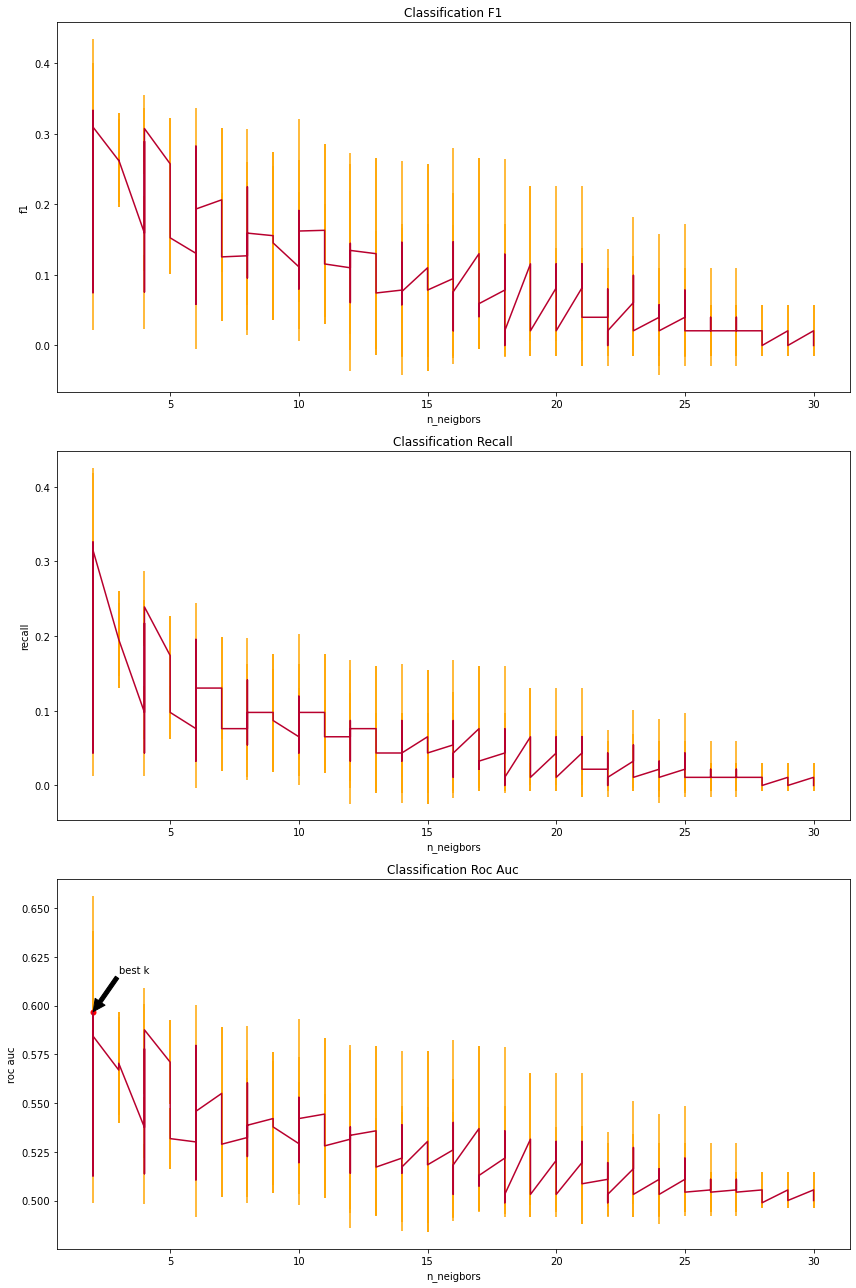



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

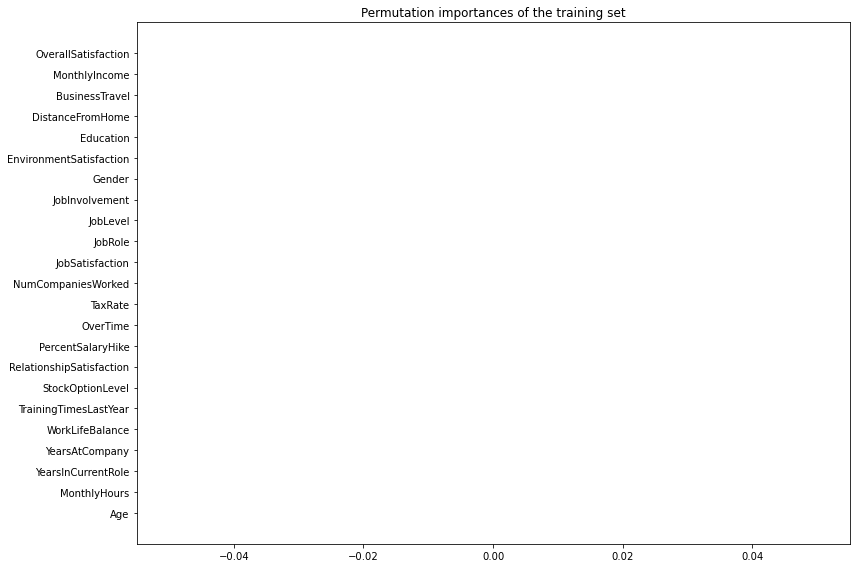



Predictions

Permutation importances of the test set

YearsAtCompany                                     0.040460
OverTime                                           0.038958
NumCompaniesWorked                                 0.030020
EnvironmentSatisfaction                            0.028062
JobLevel                                           0.024607
PercentSalaryHike                                  0.023608
JobSatisfaction                                    0.021046
DistanceFromHome                                   0.017594
JobInvolvement                                     0.017585
Age                                                0.017305
StockOptionLevel                                   0.015442
MonthlyHours                                       0.013353
YearsInCurrentRole                                 0.012499
WorkLifeBalance                                    0.007707
RelationshipSatisfaction                           0.006283
BusinessTravel                              

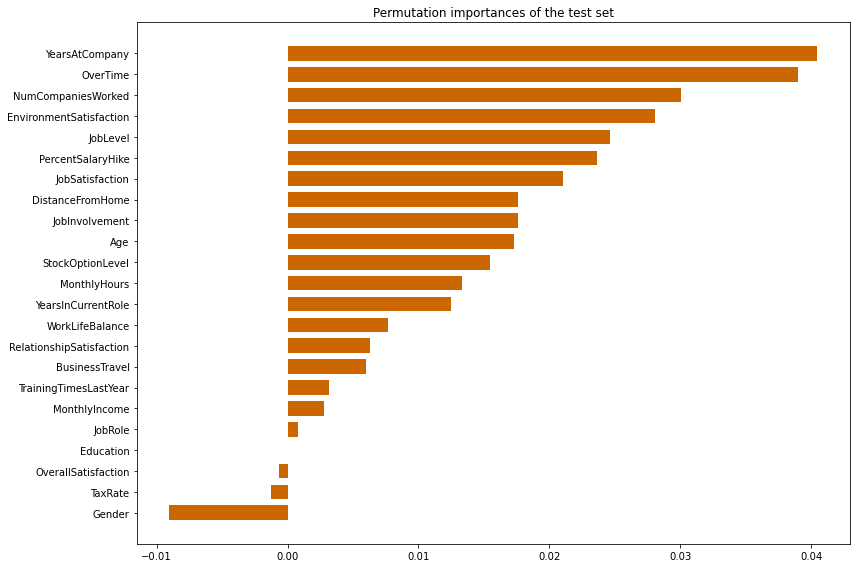



Confusion matrix


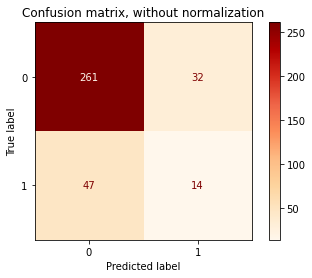

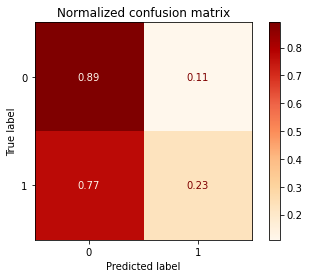


Classification report
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       293
           1       0.30      0.23      0.26        61

    accuracy                           0.78       354
   macro avg       0.58      0.56      0.57       354
weighted avg       0.75      0.78      0.76       354


Metrics

Accuracy 0.7768361581920904
F1-score [0.86855241 0.26168224]
Precision [0.8474026  0.30434783]
Recall [0.89078498 0.2295082 ]
Roc_auc 0.5601465898282325


Roc curve



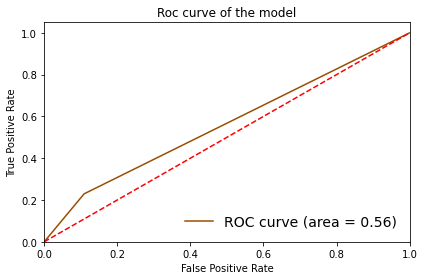


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6010396380490499
Best parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


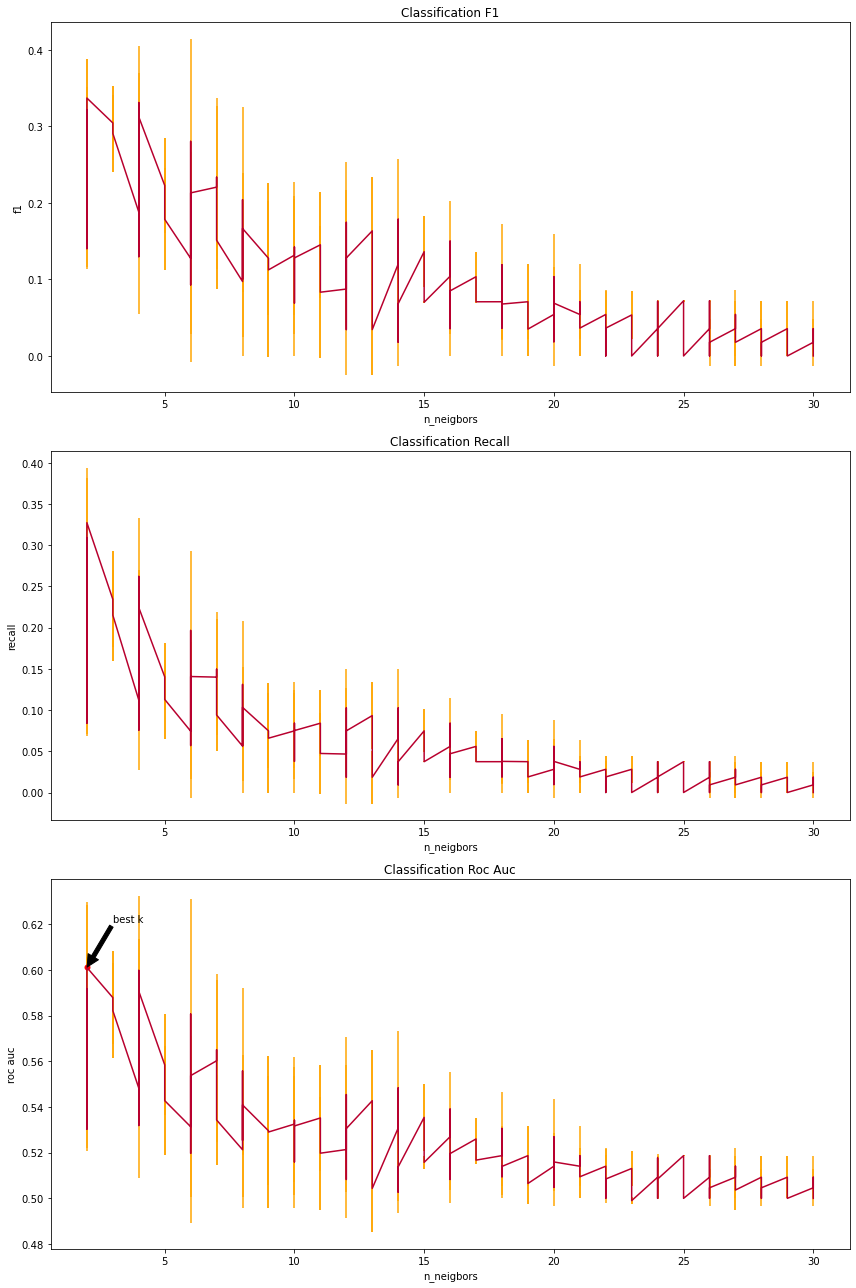



Permutation importances of the training set

OverTime                                           0.057232
Gender                                             0.044757
RelationshipSatisfaction                           0.014025
EnvironmentSatisfaction                            0.012336
JobSatisfaction                                    0.010225
BusinessTravel                                     0.004480
StockOptionLevel                                   0.004095
YearsAtCompany                                     0.001570
NumCompaniesWorked                                 0.001531
DistanceFromHome                                   0.001058
TaxRate                                            0.000040
JobInvolvement                                     0.000013
WorkLifeBalance                                    0.000005
Age                                                0.000000
Education                                          0.000000
JobLevel                                           0.

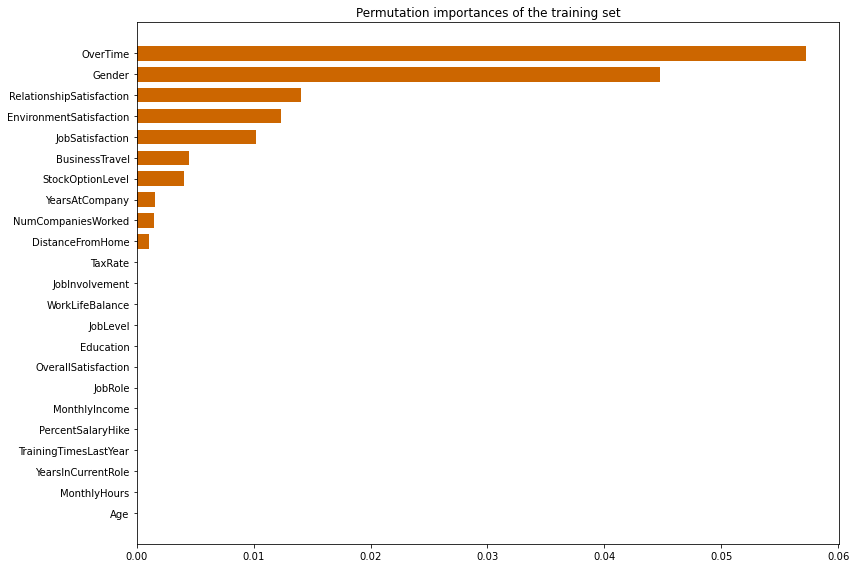



Predictions

Permutation importances of the test set

OverTime                                           0.048963
EnvironmentSatisfaction                            0.029383
PercentSalaryHike                                  0.028529
YearsAtCompany                                     0.026916
StockOptionLevel                                   0.020136
JobLevel                                           0.018270
JobSatisfaction                                    0.017972
YearsInCurrentRole                                 0.015892
JobRole                                            0.011078
OverallSatisfaction                                0.010358
Education                                          0.009237
NumCompaniesWorked                                 0.006690
MonthlyHours                                       0.005390
MonthlyIncome                                      0.005013
BusinessTravel                                     -0.000055
DistanceFromHome                           

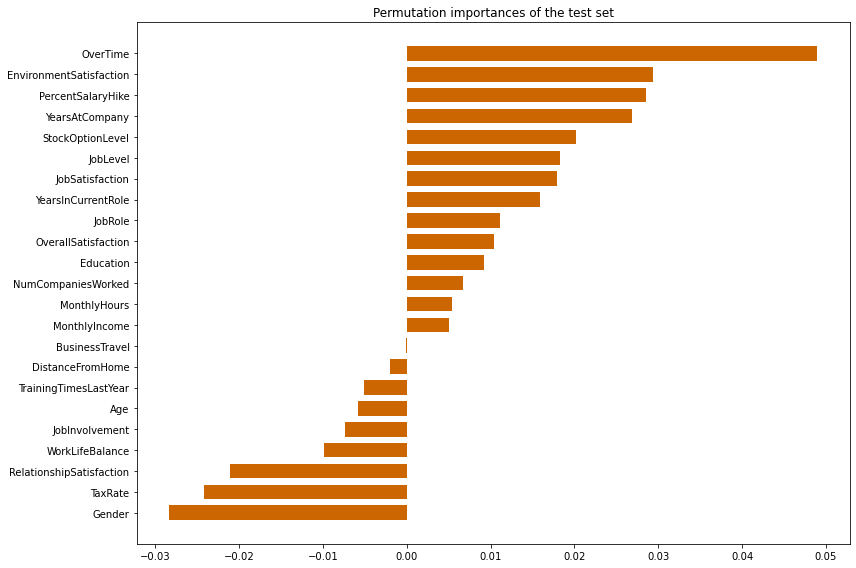



Confusion matrix


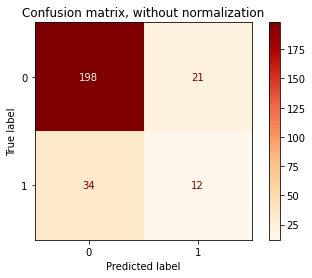

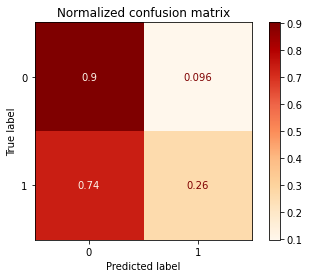


Classification report
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       219
           1       0.36      0.26      0.30        46

    accuracy                           0.79       265
   macro avg       0.61      0.58      0.59       265
weighted avg       0.77      0.79      0.78       265


Metrics

Accuracy 0.7924528301886793
F1-score [0.87804878 0.30379747]
Precision [0.85344828 0.36363636]
Recall [0.90410959 0.26086957]
Roc_auc 0.5824895771292437


Roc curve



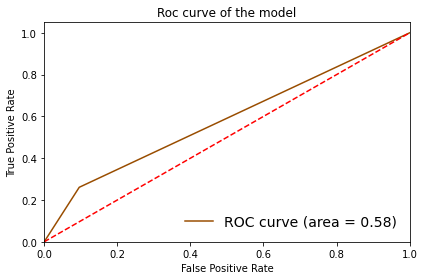


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6108723670643689
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


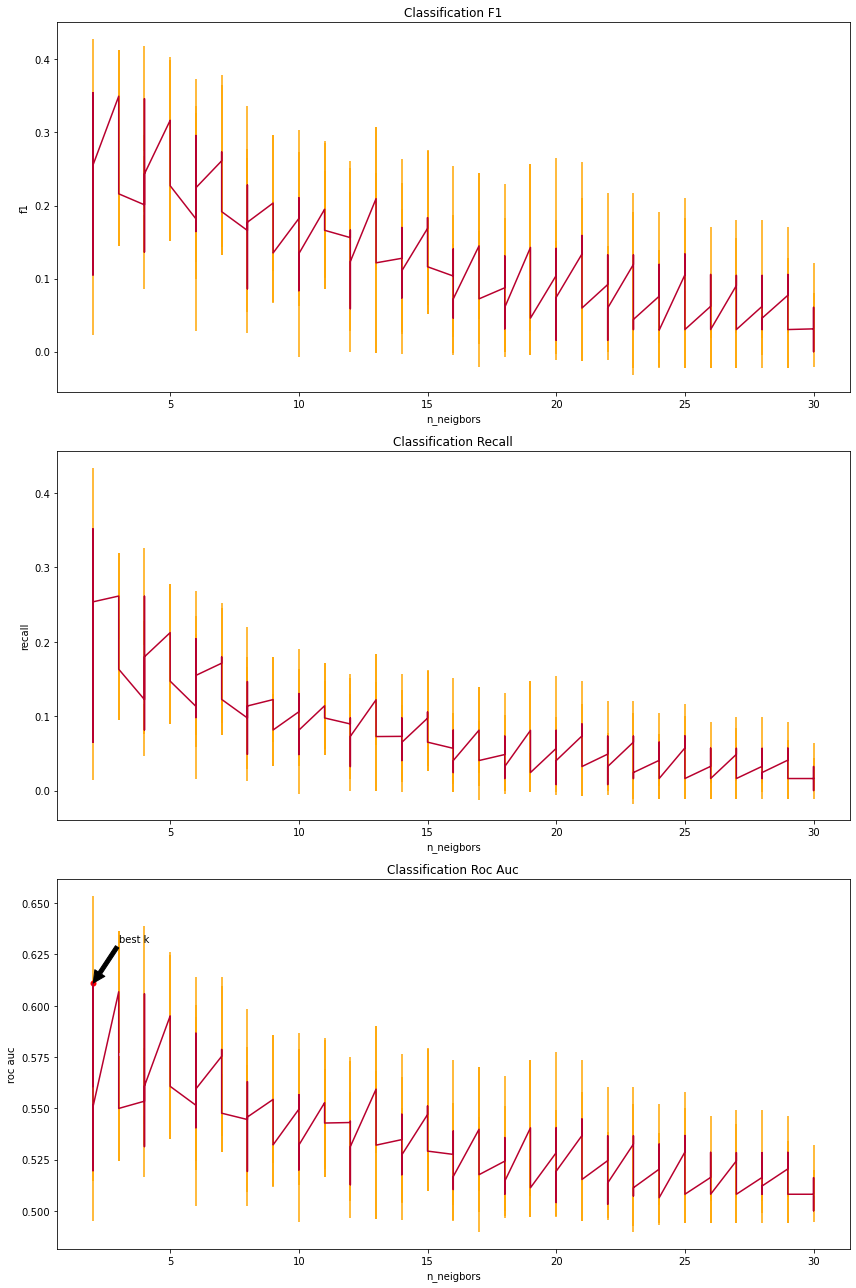



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

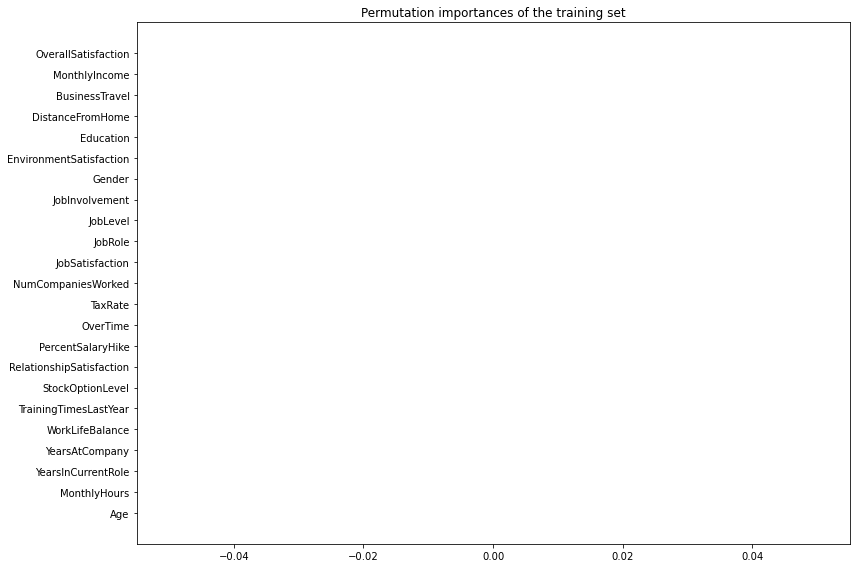



Predictions

Permutation importances of the test set

EnvironmentSatisfaction                            0.037892
OverTime                                           0.036246
BusinessTravel                                     0.024359
DistanceFromHome                                   0.022978
NumCompaniesWorked                                 0.022570
MonthlyHours                                       0.021299
PercentSalaryHike                                  0.019775
WorkLifeBalance                                    0.017123
RelationshipSatisfaction                           0.016184
MonthlyIncome                                      0.015334
JobLevel                                           0.011699
JobSatisfaction                                    0.007589
JobInvolvement                                     0.004065
StockOptionLevel                                   0.001646
OverallSatisfaction                                0.000696
TaxRate                                     

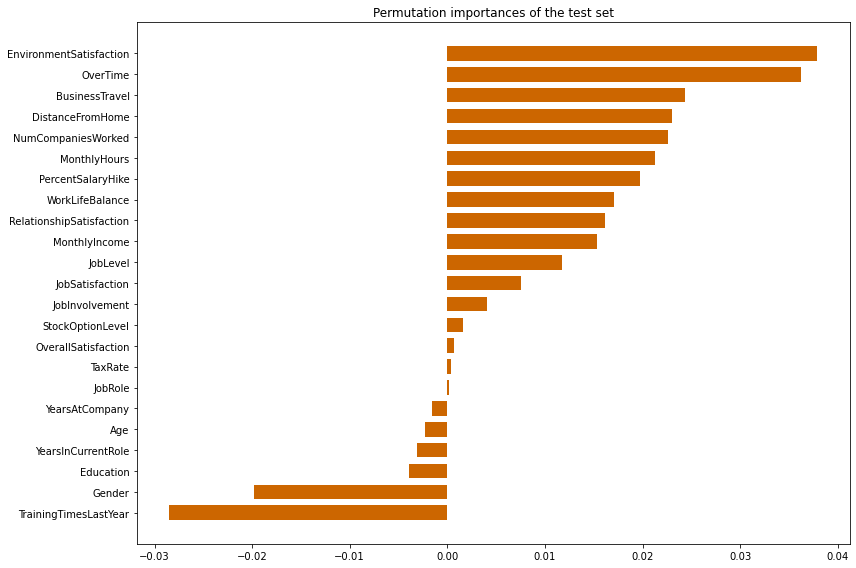



Confusion matrix


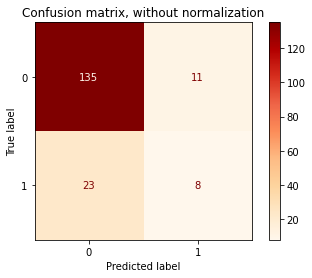

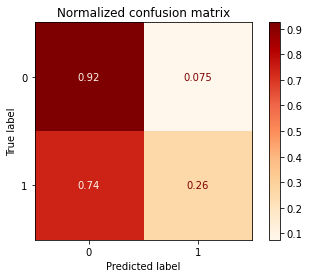


Classification report
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       146
           1       0.42      0.26      0.32        31

    accuracy                           0.81       177
   macro avg       0.64      0.59      0.60       177
weighted avg       0.78      0.81      0.79       177


Metrics

Accuracy 0.807909604519774
F1-score [0.88815789 0.32      ]
Precision [0.85443038 0.42105263]
Recall [0.92465753 0.25806452]
Roc_auc 0.5913610251878038


Roc curve



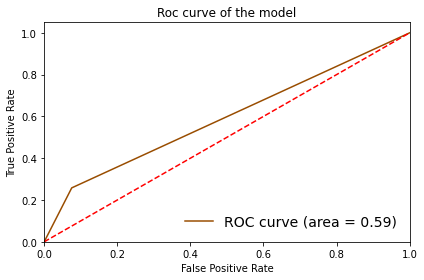


-------------------------------------------------------------------------------------------------------------



In [14]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5955393081190847
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


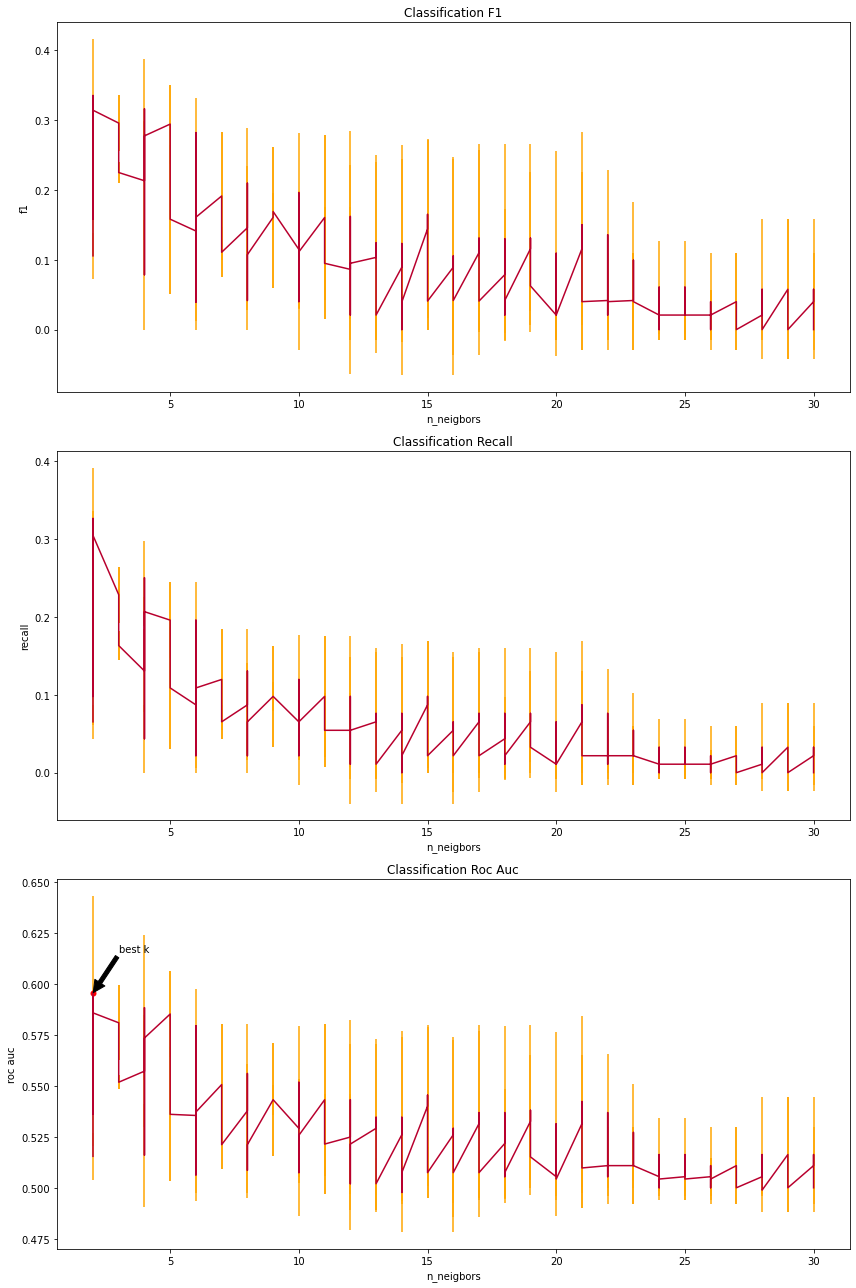



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

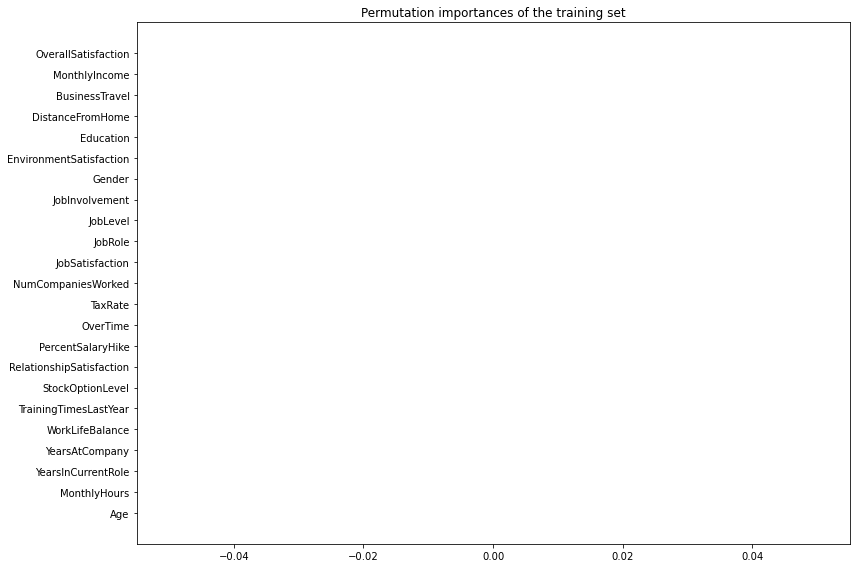



Predictions

Permutation importances of the test set

OverTime                                           0.036852
YearsAtCompany                                     0.034597
YearsInCurrentRole                                 0.022207
Age                                                0.017476
JobSatisfaction                                    0.016214
NumCompaniesWorked                                 0.015848
MonthlyHours                                       0.013946
PercentSalaryHike                                  0.012684
StockOptionLevel                                   0.011112
JobLevel                                           0.008798
WorkLifeBalance                                    0.008765
JobInvolvement                                     0.006348
DistanceFromHome                                   0.002968
EnvironmentSatisfaction                            -0.000876
OverallSatisfaction                                -0.002428
BusinessTravel                            

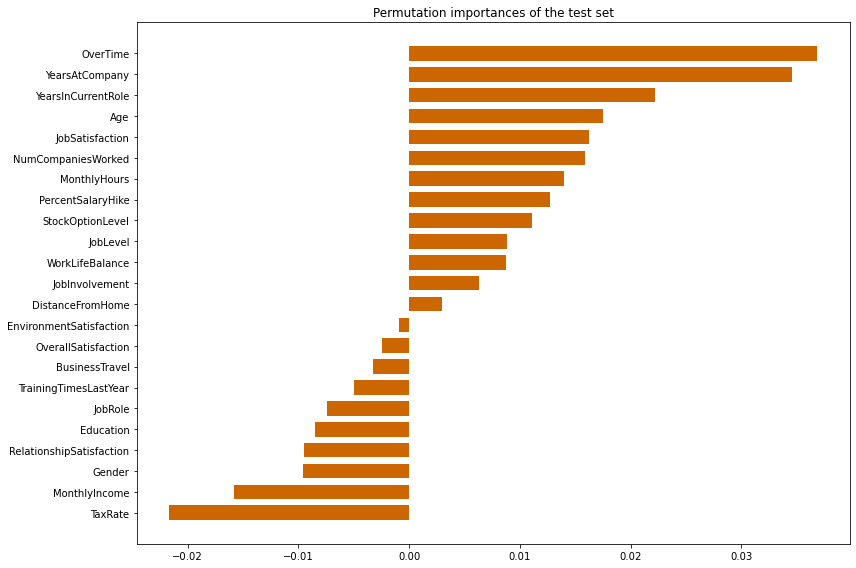



Confusion matrix


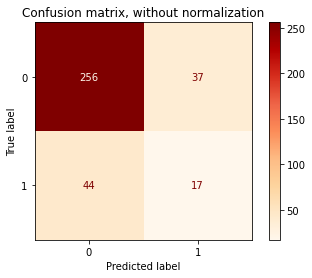

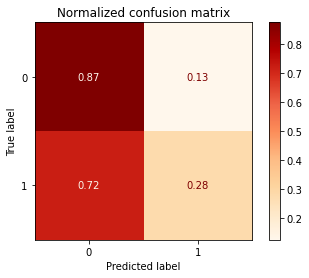


Classification report
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       293
           1       0.31      0.28      0.30        61

    accuracy                           0.77       354
   macro avg       0.58      0.58      0.58       354
weighted avg       0.76      0.77      0.77       354


Metrics

Accuracy 0.7711864406779662
F1-score [0.86340641 0.29565217]
Precision [0.85333333 0.31481481]
Recall [0.87372014 0.27868852]
Roc_auc 0.5762043305544676


Roc curve



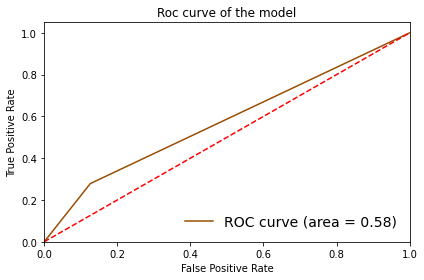


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6087770178567422
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


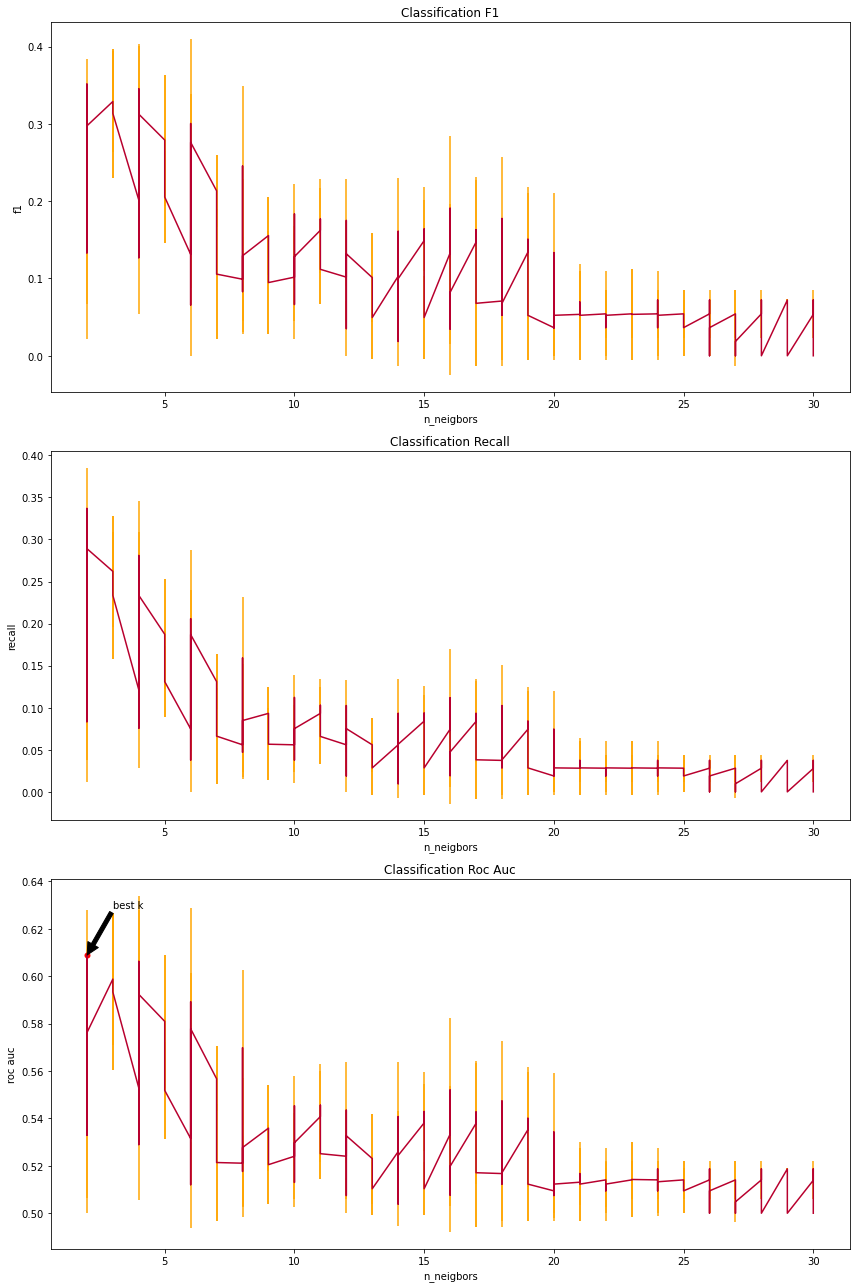



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

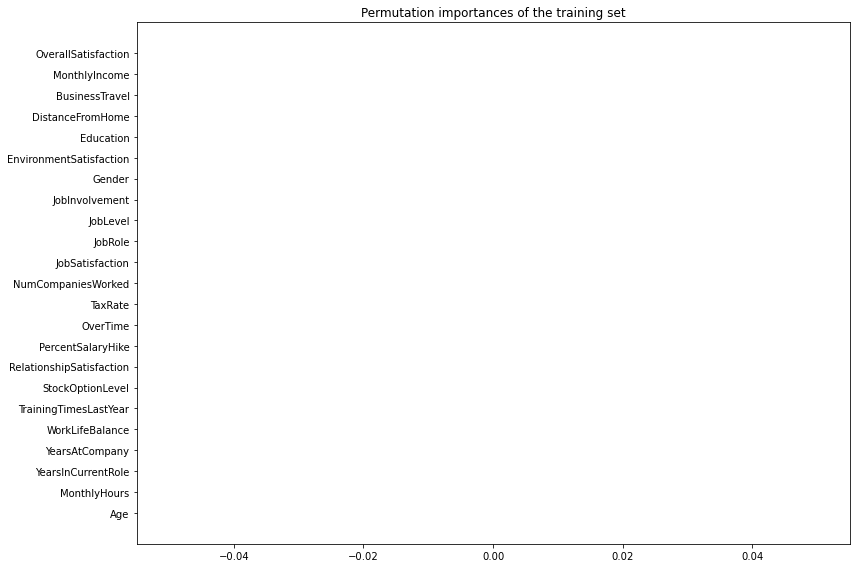



Predictions

Permutation importances of the test set

OverTime                                           0.050154
NumCompaniesWorked                                 0.039805
EnvironmentSatisfaction                            0.038599
YearsAtCompany                                     0.032996
JobLevel                                           0.027298
JobInvolvement                                     0.021789
YearsInCurrentRole                                 0.018300
JobSatisfaction                                    0.016066
PercentSalaryHike                                  0.015287
StockOptionLevel                                   0.015083
Age                                                0.013227
WorkLifeBalance                                    0.012463
MonthlyHours                                       0.008443
OverallSatisfaction                                0.007544
JobRole                                            0.007316
DistanceFromHome                            

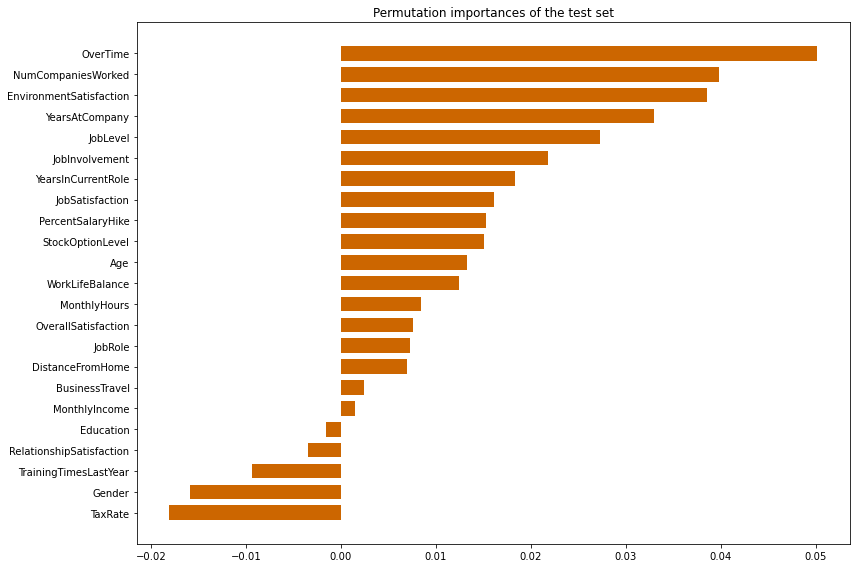



Confusion matrix


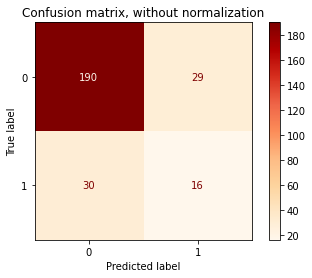

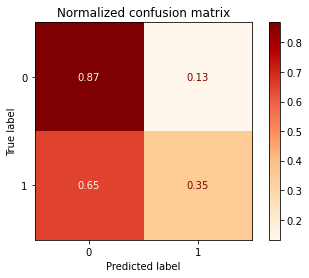


Classification report
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       219
           1       0.36      0.35      0.35        46

    accuracy                           0.78       265
   macro avg       0.61      0.61      0.61       265
weighted avg       0.78      0.78      0.78       265


Metrics

Accuracy 0.7773584905660378
F1-score [0.86560364 0.35164835]
Precision [0.86363636 0.35555556]
Recall [0.86757991 0.34782609]
Roc_auc 0.6077029978161604


Roc curve



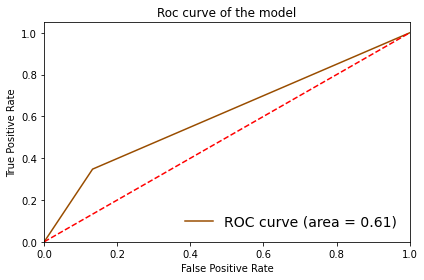


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.626132346442775
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


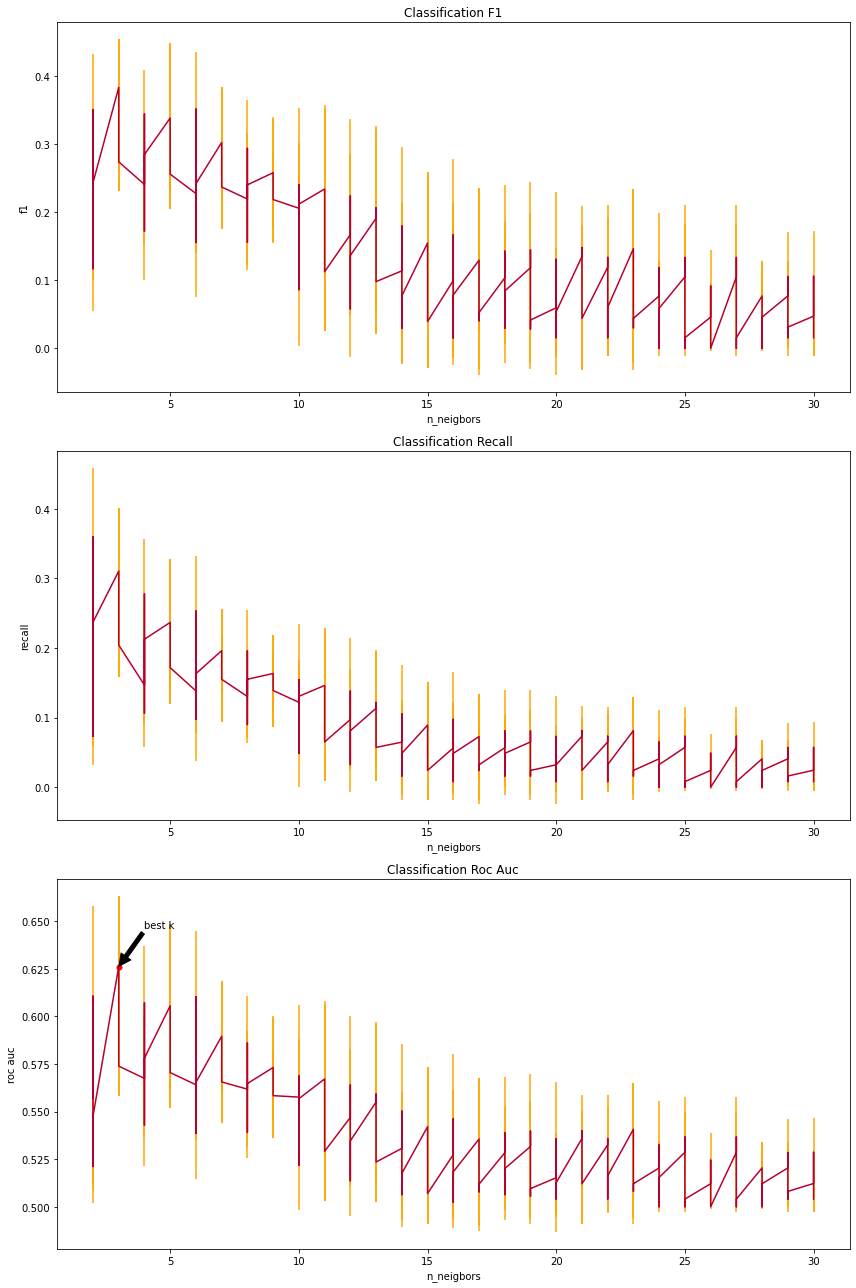



Permutation importances of the training set

OverTime                                           0.014764
YearsAtCompany                                     0.006679
StockOptionLevel                                   0.003707
JobLevel                                           0.003067
EnvironmentSatisfaction                            0.001935
YearsInCurrentRole                                 0.001287
Age                                                0.000581
MonthlyIncome                                      -0.000018
JobRole                                            -0.000492
PercentSalaryHike                                  -0.001020
NumCompaniesWorked                                 -0.001611
MonthlyHours                                       -0.001784
RelationshipSatisfaction                           -0.002927
JobSatisfaction                                    -0.003077
DistanceFromHome                                   -0.003778
BusinessTravel                               

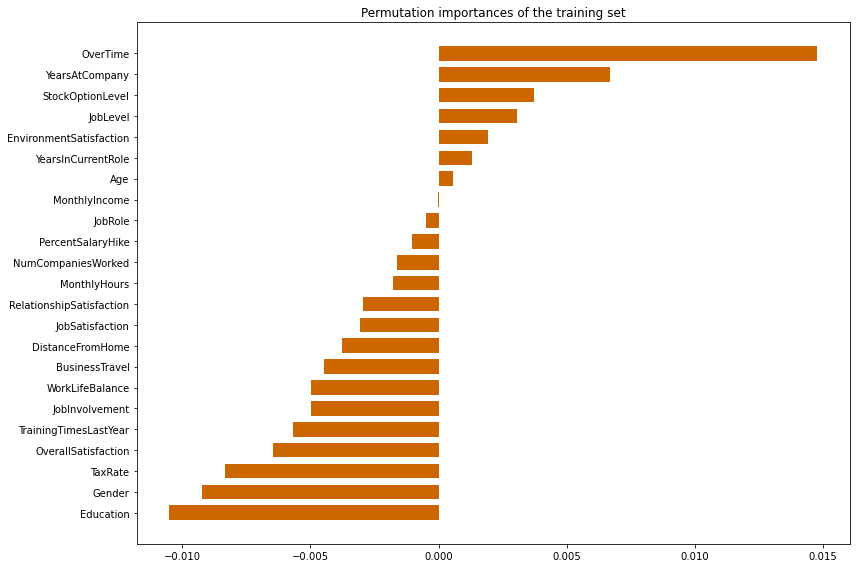



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.011114
BusinessTravel                                     0.007446
OverallSatisfaction                                0.002839
NumCompaniesWorked                                 0.002519
OverTime                                           0.000630
PercentSalaryHike                                  0.000586
YearsInCurrentRole                                 -0.002861
JobSatisfaction                                    -0.002950
Age                                                -0.010859
YearsAtCompany                                     -0.014781
JobInvolvement                                     -0.020040
Gender                                             -0.020913
TrainingTimesLastYear                              -0.023034
TaxRate                                            -0.025331
JobRole                                            -0.025597
EnvironmentSatisfaction            

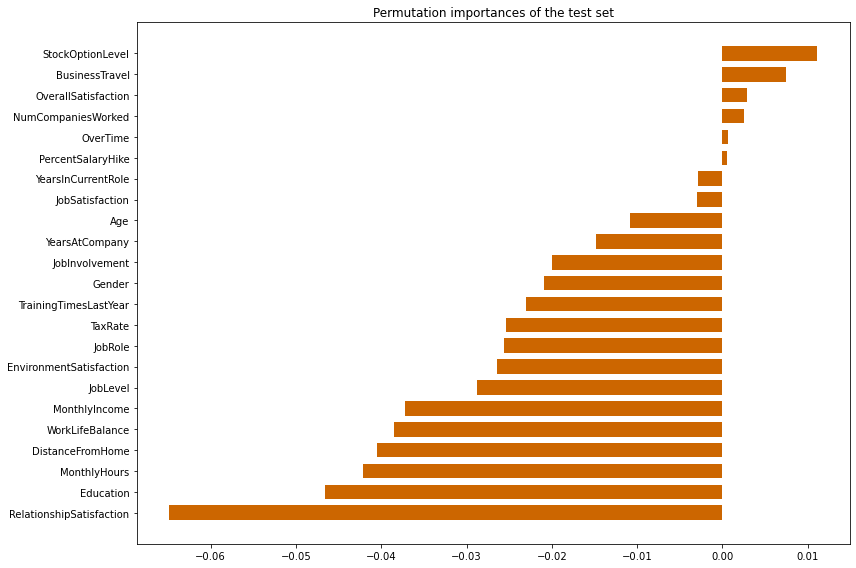



Confusion matrix


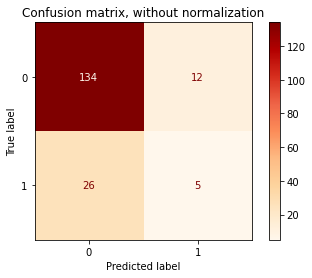

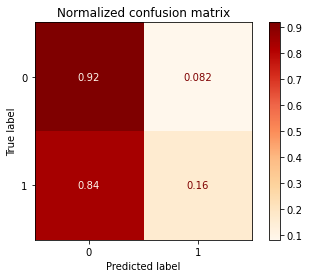


Classification report
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       146
           1       0.29      0.16      0.21        31

    accuracy                           0.79       177
   macro avg       0.57      0.54      0.54       177
weighted avg       0.74      0.79      0.76       177


Metrics

Accuracy 0.7853107344632768
F1-score [0.87581699 0.20833333]
Precision [0.8375     0.29411765]
Recall [0.91780822 0.16129032]
Roc_auc 0.5395492708793638


Roc curve



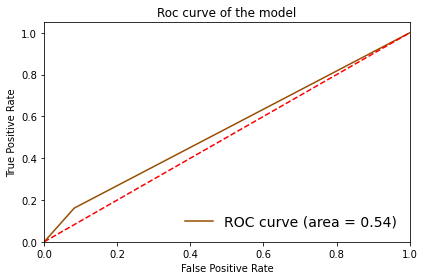


-------------------------------------------------------------------------------------------------------------



In [15]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5855128367842767
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


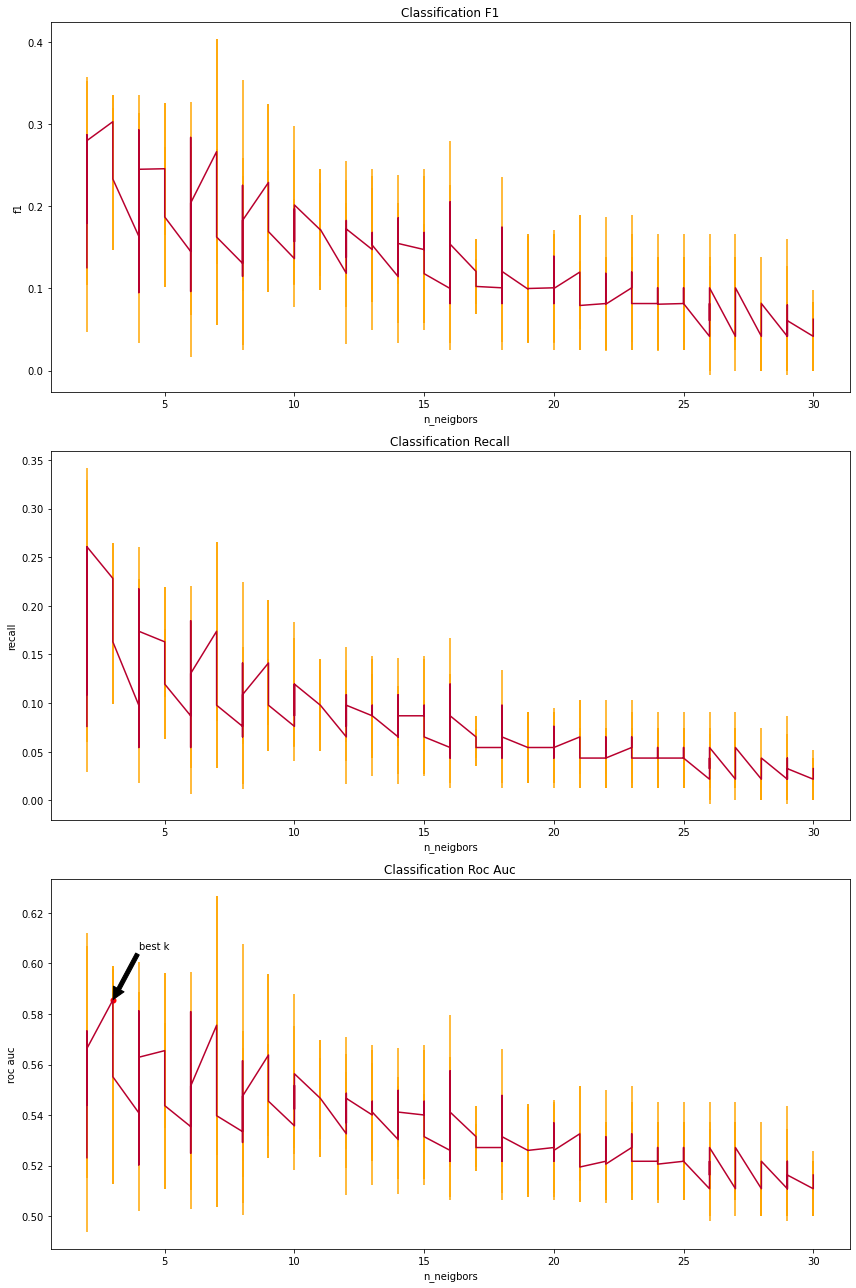



Permutation importances of the training set

YearsInCurrentRole                                 0.008033
StockOptionLevel                                   0.002822
OverTime                                           0.002808
RelationshipSatisfaction                           0.002439
MonthlyHours                                       0.002389
TaxRate                                            0.001887
Education                                          0.001617
JobRole                                            0.001573
TrainingTimesLastYear                              0.001205
Gender                                             0.000102
PercentSalaryHike                                  -0.000349
WorkLifeBalance                                    -0.000358
Age                                                -0.000611
DistanceFromHome                                   -0.001169
JobSatisfaction                                    -0.002499
BusinessTravel                                  

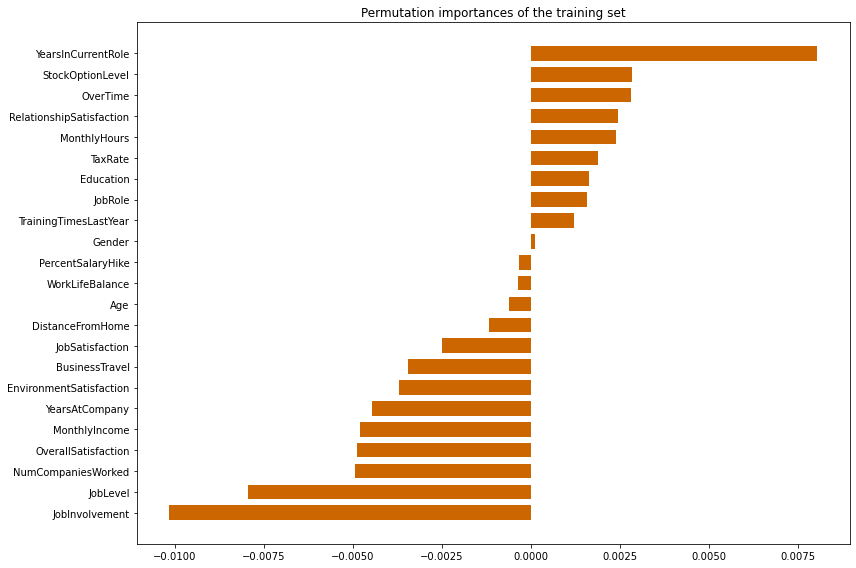



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.034605
Age                                                0.033788
OverTime                                           0.028946
RelationshipSatisfaction                           0.023426
JobSatisfaction                                    0.012883
YearsAtCompany                                     0.011593
JobRole                                            0.007162
TaxRate                                            0.006563
EnvironmentSatisfaction                            0.006521
OverallSatisfaction                                0.002031
BusinessTravel                                     -0.000394
MonthlyIncome                                      -0.001329
JobInvolvement                                     -0.001743
NumCompaniesWorked                                 -0.004152
JobLevel                                           -0.005189
WorkLifeBalance                        

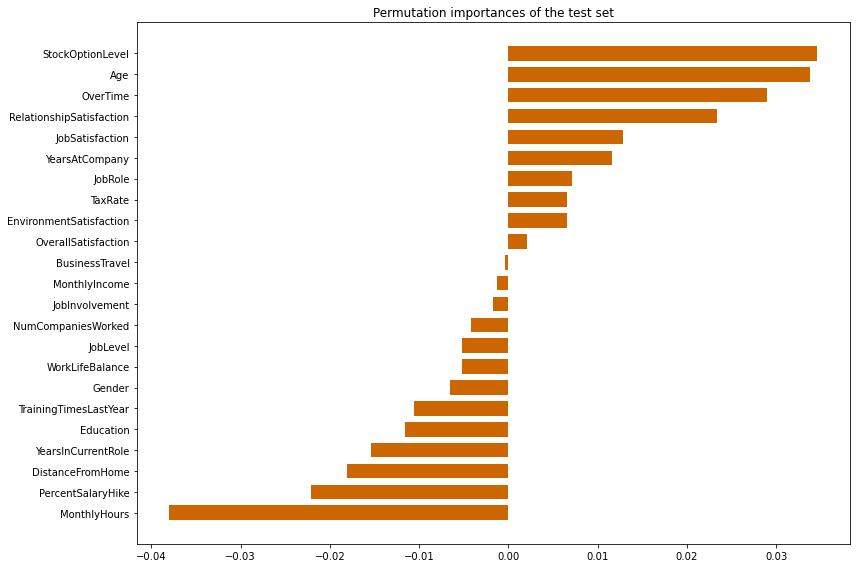



Confusion matrix


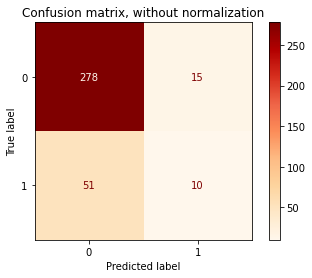

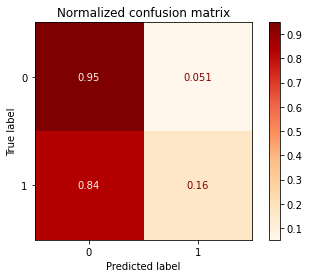


Classification report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       293
           1       0.40      0.16      0.23        61

    accuracy                           0.81       354
   macro avg       0.62      0.56      0.56       354
weighted avg       0.77      0.81      0.78       354


Metrics

Accuracy 0.8135593220338984
F1-score [0.89389068 0.23255814]
Precision [0.8449848 0.4      ]
Recall [0.94880546 0.16393443]
Roc_auc 0.5563699434901808


Roc curve



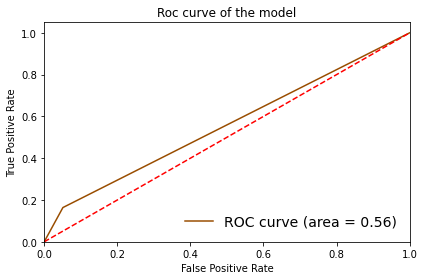


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5783925978854005
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


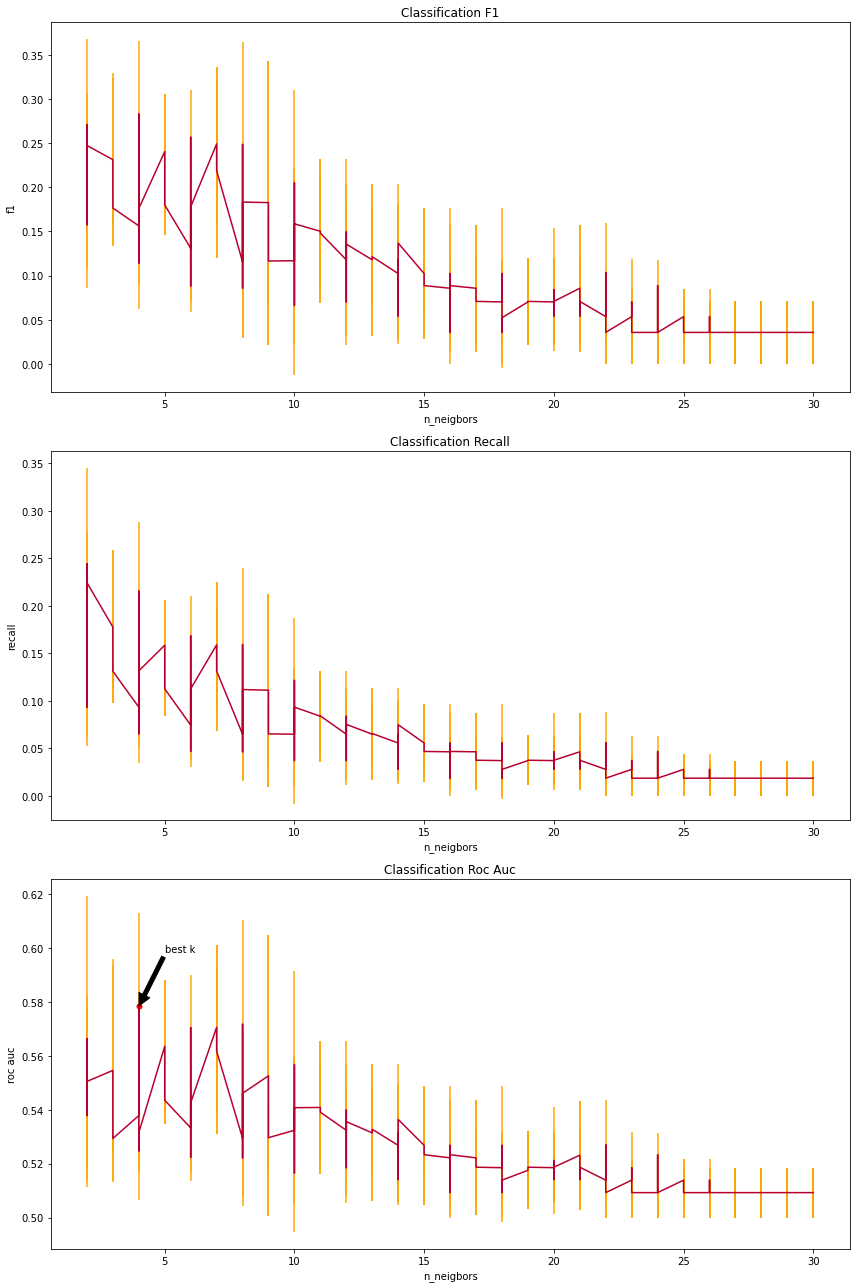



Permutation importances of the training set

TrainingTimesLastYear                              0.000042
Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.

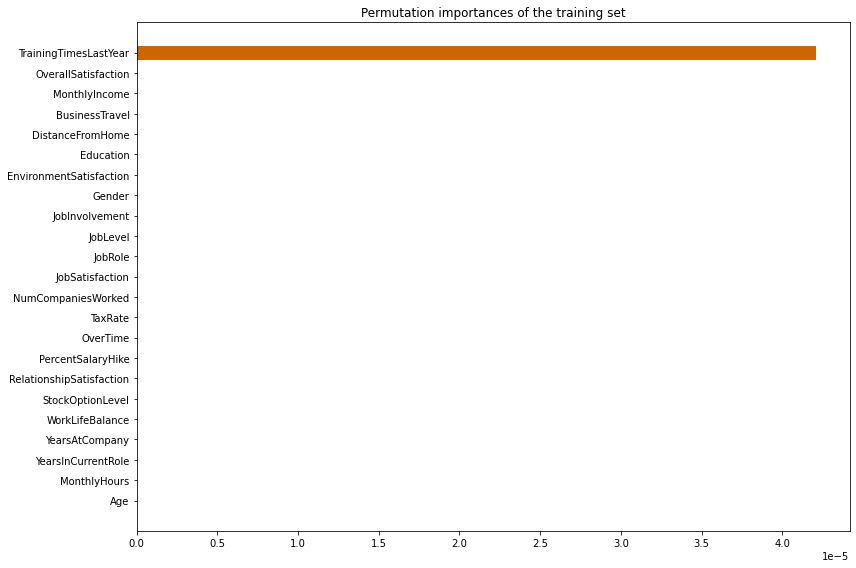



Predictions

Permutation importances of the test set

JobSatisfaction                                    0.055331
OverTime                                           0.031894
JobInvolvement                                     0.024677
YearsAtCompany                                     0.019828
TaxRate                                            0.015277
StockOptionLevel                                   0.015207
OverallSatisfaction                                0.014885
PercentSalaryHike                                  0.011971
JobRole                                            0.011917
MonthlyIncome                                      0.010924
Age                                                0.005772
NumCompaniesWorked                                 0.005211
JobLevel                                           0.002541
EnvironmentSatisfaction                            0.002407
RelationshipSatisfaction                           0.001668
YearsInCurrentRole                          

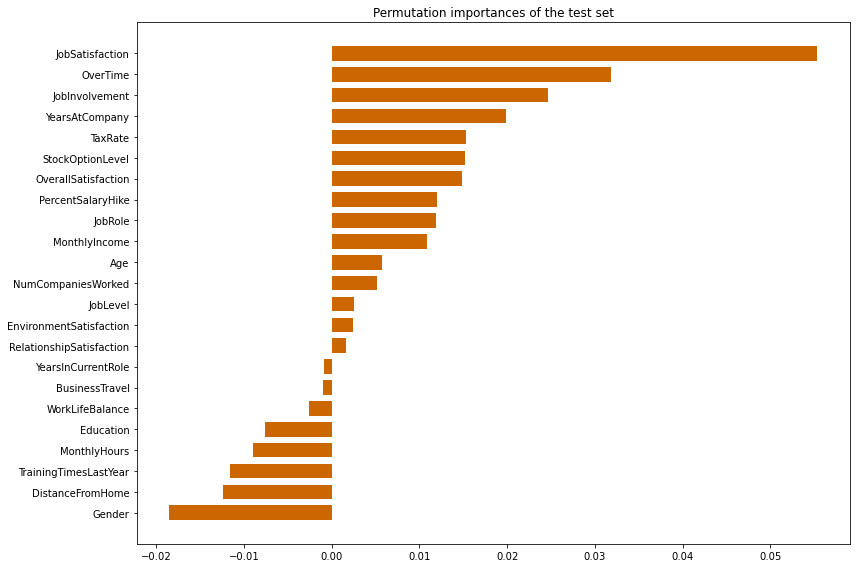



Confusion matrix


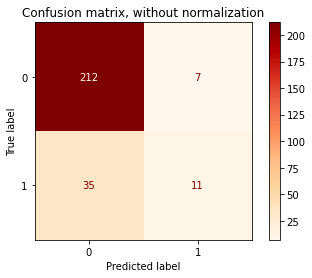

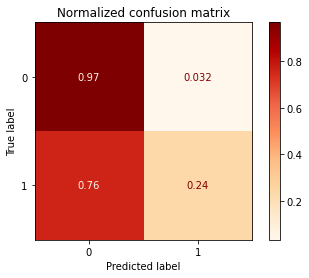


Classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       219
           1       0.61      0.24      0.34        46

    accuracy                           0.84       265
   macro avg       0.73      0.60      0.63       265
weighted avg       0.82      0.84      0.81       265


Metrics

Accuracy 0.8415094339622642
F1-score [0.90987124 0.34375   ]
Precision [0.8582996  0.61111111]
Recall [0.96803653 0.23913043]
Roc_auc 0.603583482231487


Roc curve



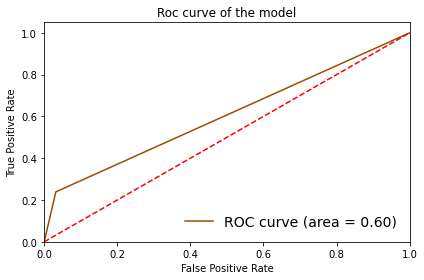


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6053560907350125
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


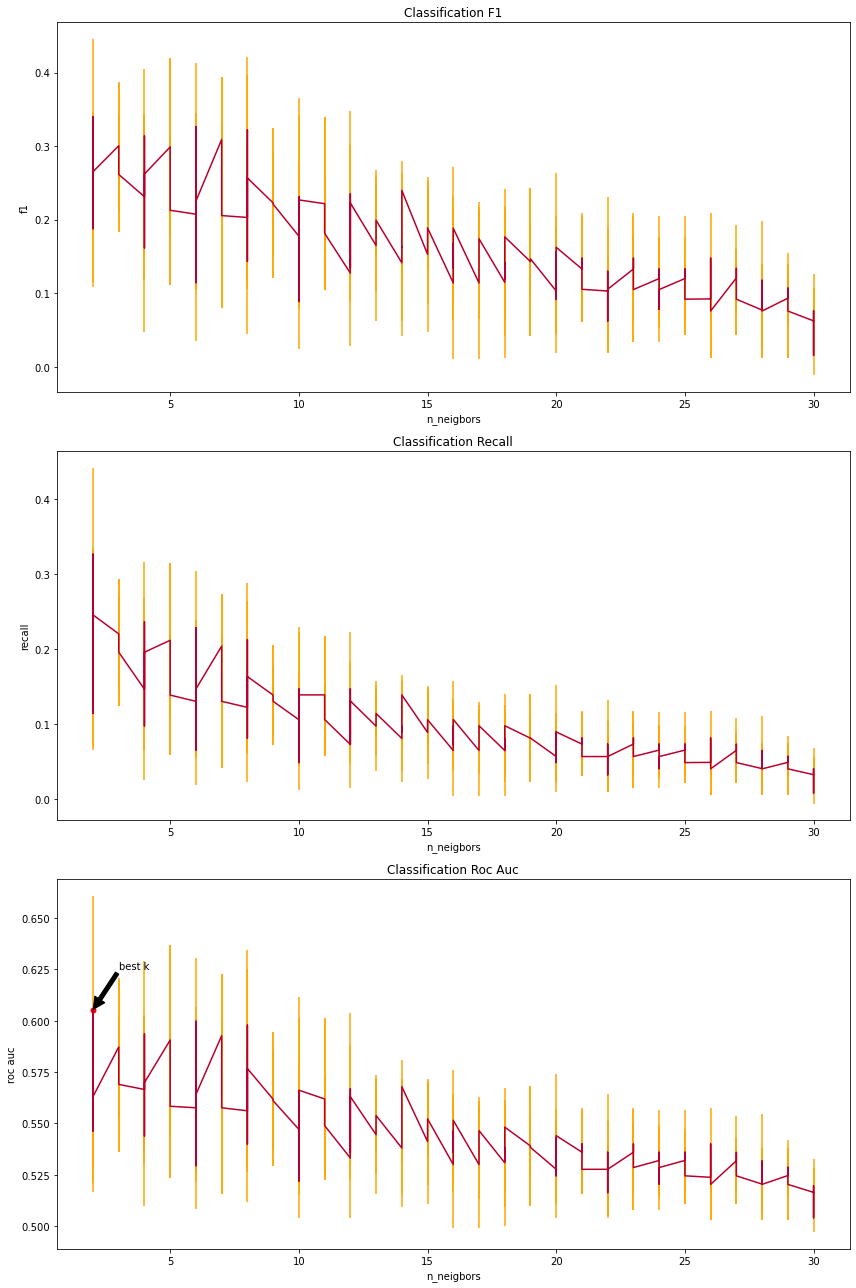



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

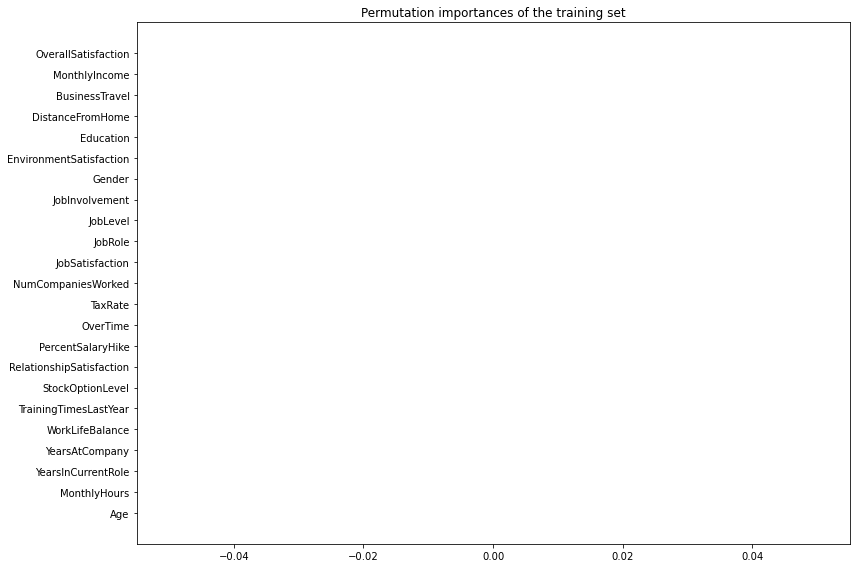



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.053292
JobSatisfaction                                    0.045007
WorkLifeBalance                                    0.037517
YearsInCurrentRole                                 0.032589
BusinessTravel                                     0.028093
JobRole                                            0.025530
JobInvolvement                                     0.025099
YearsAtCompany                                     0.020813
DistanceFromHome                                   0.015787
TaxRate                                            0.009412
Education                                          0.007468
NumCompaniesWorked                                 0.007468
OverTime                                           0.004176
RelationshipSatisfaction                           0.002928
PercentSalaryHike                                  0.001900
Age                                         

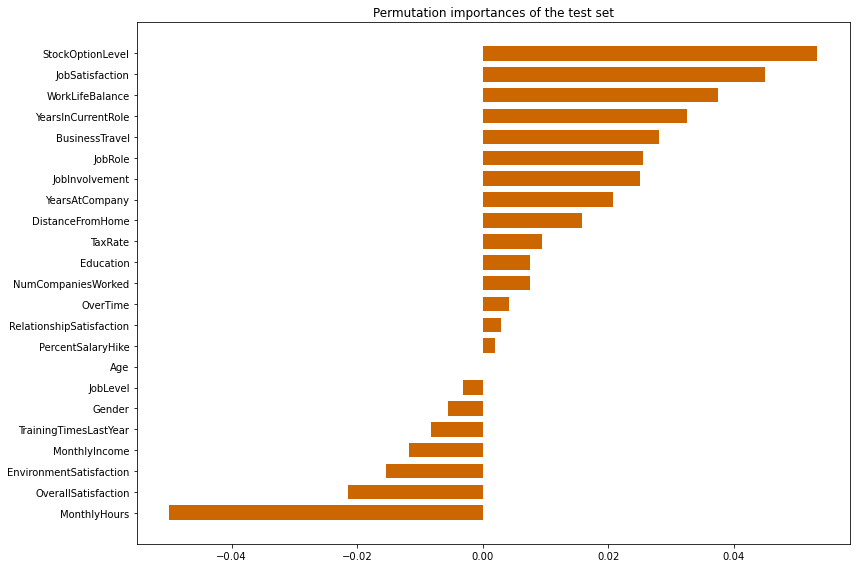



Confusion matrix


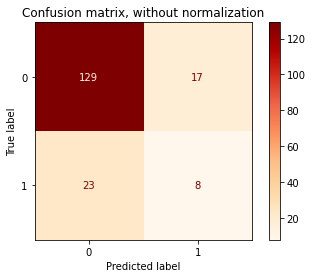

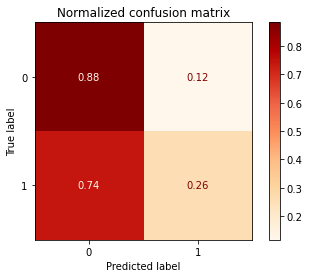


Classification report
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       146
           1       0.32      0.26      0.29        31

    accuracy                           0.77       177
   macro avg       0.58      0.57      0.58       177
weighted avg       0.76      0.77      0.76       177


Metrics

Accuracy 0.7740112994350282
F1-score [0.86577181 0.28571429]
Precision [0.84868421 0.32      ]
Recall [0.88356164 0.25806452]
Roc_auc 0.5708130799823243


Roc curve



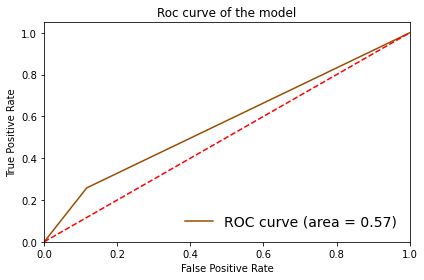


-------------------------------------------------------------------------------------------------------------



In [16]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6018380353192878
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


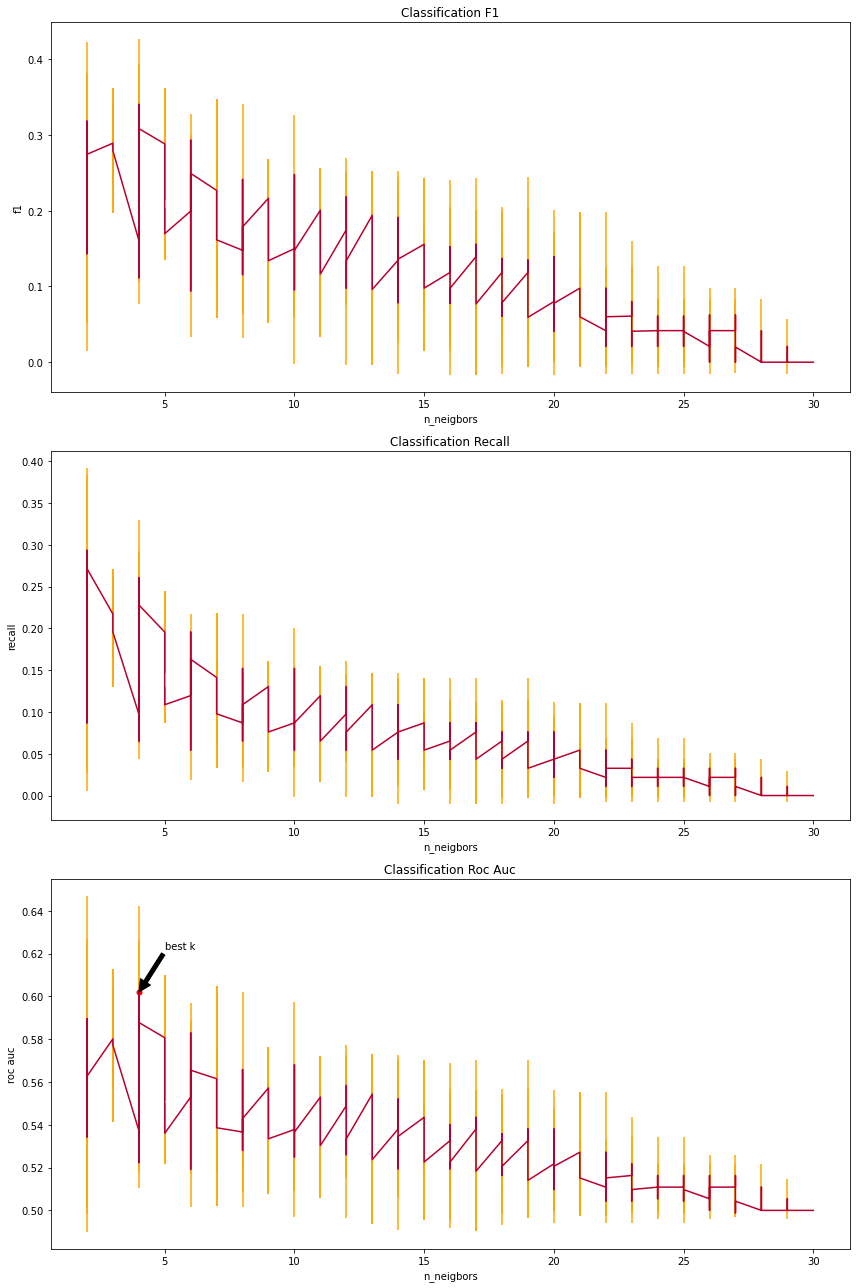



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

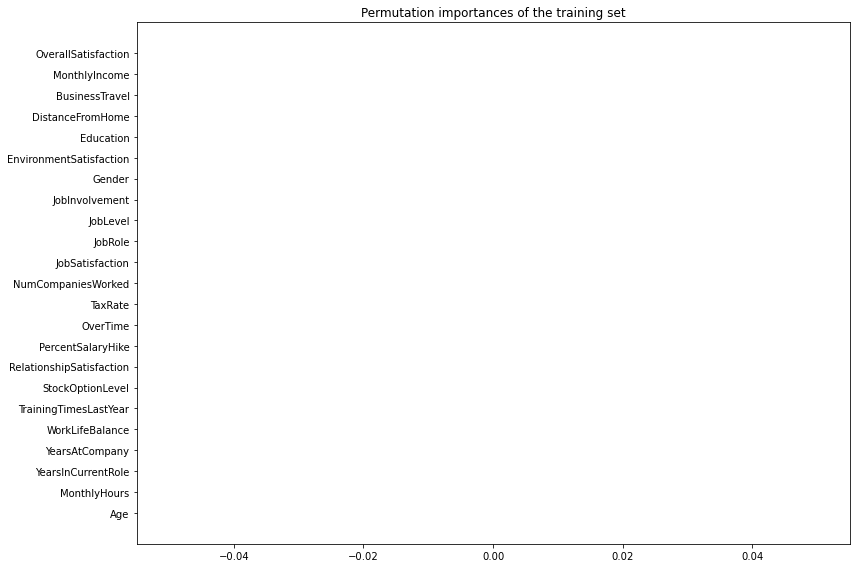



Predictions

Permutation importances of the test set

YearsAtCompany                                     0.028431
StockOptionLevel                                   0.027880
OverallSatisfaction                                0.022408
JobSatisfaction                                    0.021910
OverTime                                           0.021292
YearsInCurrentRole                                 0.020766
Age                                                0.020061
JobLevel                                           0.009856
EnvironmentSatisfaction                            0.008454
DistanceFromHome                                   0.006272
RelationshipSatisfaction                           0.004563
NumCompaniesWorked                                 0.002820
BusinessTravel                                     -0.000515
JobRole                                            -0.001953
JobInvolvement                                     -0.002887
Gender                                   

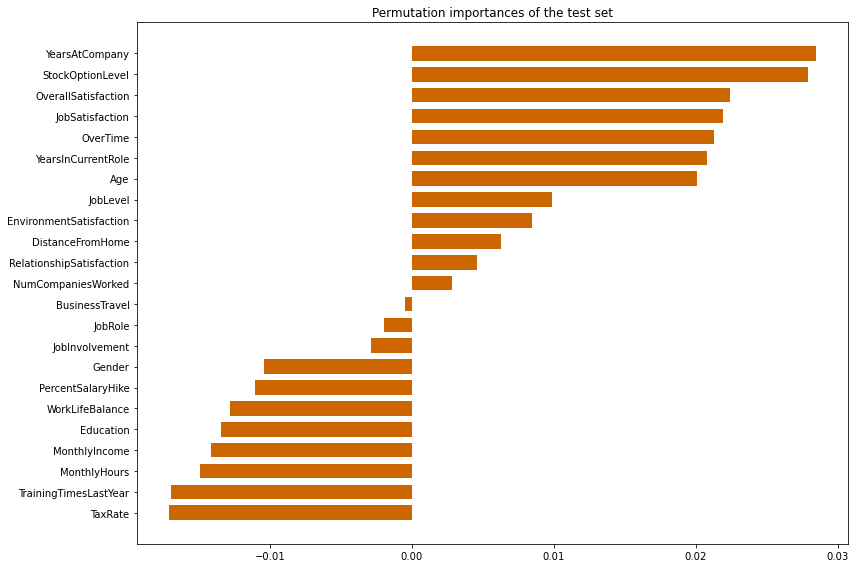



Confusion matrix


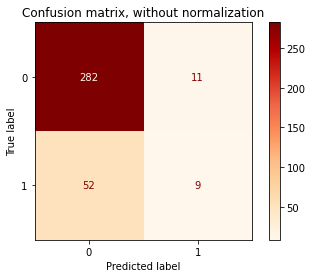

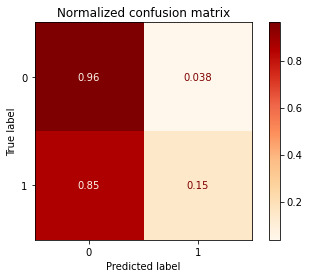


Classification report
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       293
           1       0.45      0.15      0.22        61

    accuracy                           0.82       354
   macro avg       0.65      0.55      0.56       354
weighted avg       0.78      0.82      0.78       354


Metrics

Accuracy 0.8220338983050848
F1-score [0.89952153 0.22222222]
Precision [0.84431138 0.45      ]
Recall [0.96245734 0.14754098]
Roc_auc 0.5549991607452582


Roc curve



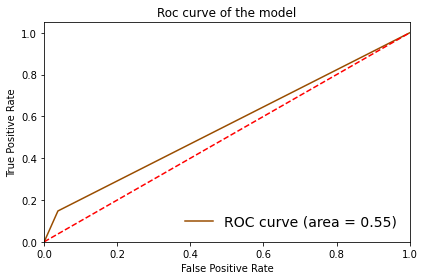


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5787698638030823
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


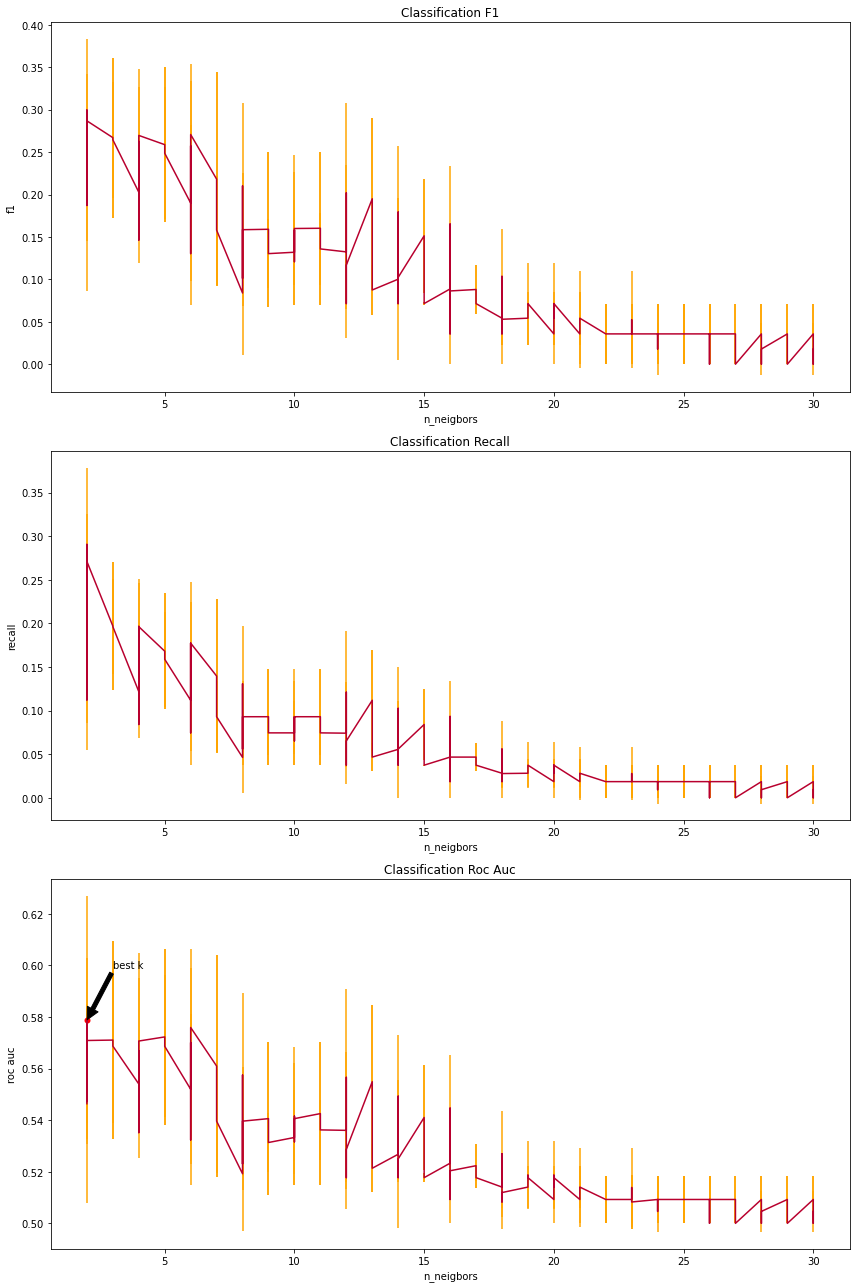



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

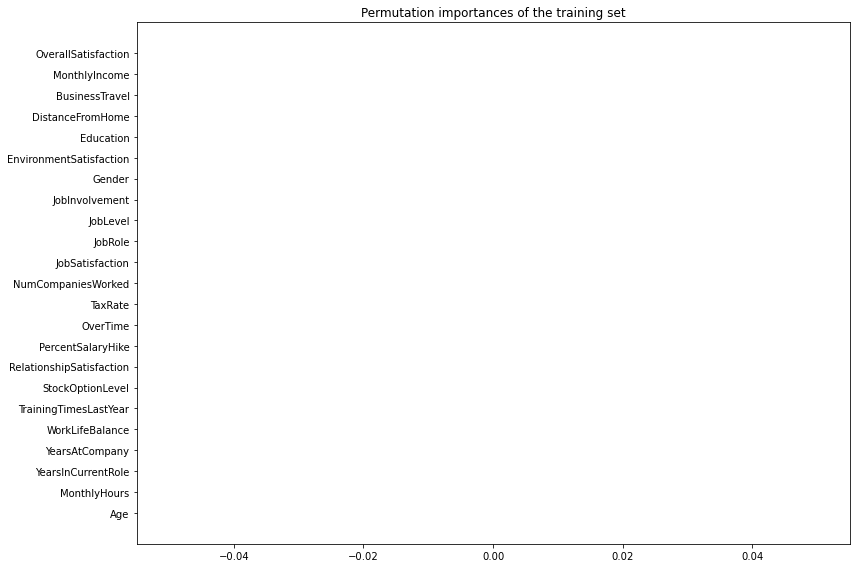



Predictions

Permutation importances of the test set

EnvironmentSatisfaction                            0.036485
OverTime                                           0.028777
NumCompaniesWorked                                 0.025938
JobInvolvement                                     0.025065
PercentSalaryHike                                  0.024643
YearsAtCompany                                     0.024543
MonthlyIncome                                      0.021233
YearsInCurrentRole                                 0.020488
BusinessTravel                                     0.019664
WorkLifeBalance                                    0.019446
JobLevel                                           0.016860
StockOptionLevel                                   0.014592
JobSatisfaction                                    0.008001
OverallSatisfaction                                0.007579
DistanceFromHome                                   0.004134
RelationshipSatisfaction                    

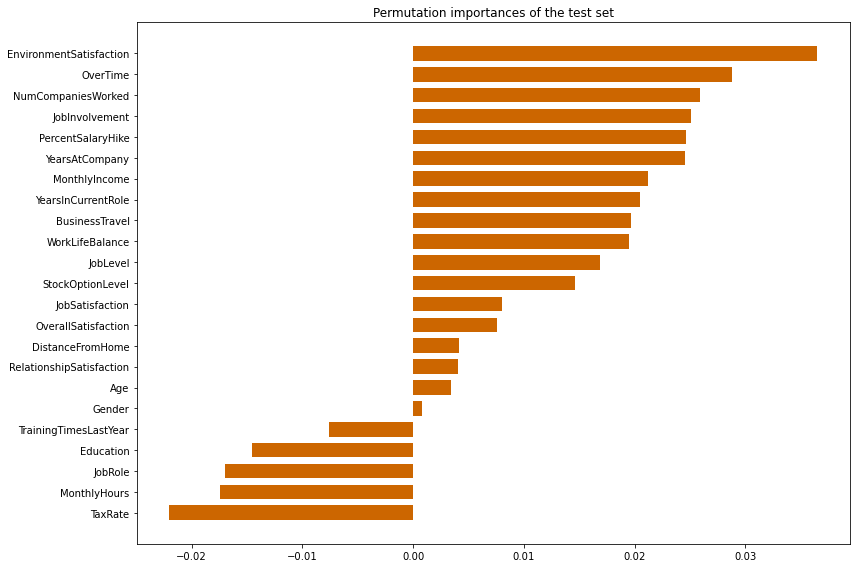



Confusion matrix


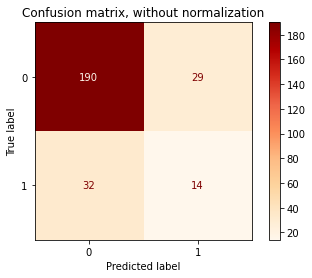

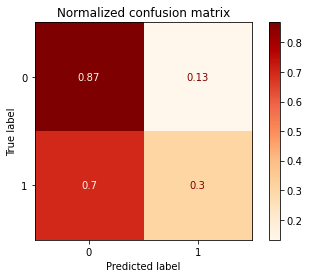


Classification report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       219
           1       0.33      0.30      0.31        46

    accuracy                           0.77       265
   macro avg       0.59      0.59      0.59       265
weighted avg       0.76      0.77      0.77       265


Metrics

Accuracy 0.769811320754717
F1-score [0.861678   0.31460674]
Precision [0.85585586 0.3255814 ]
Recall [0.86757991 0.30434783]
Roc_auc 0.5859638673813778


Roc curve



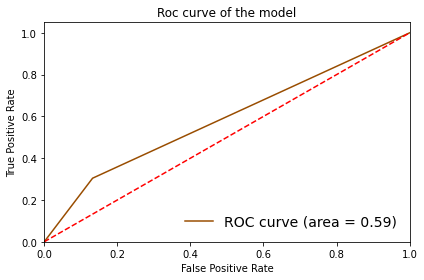


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.619038149948446
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


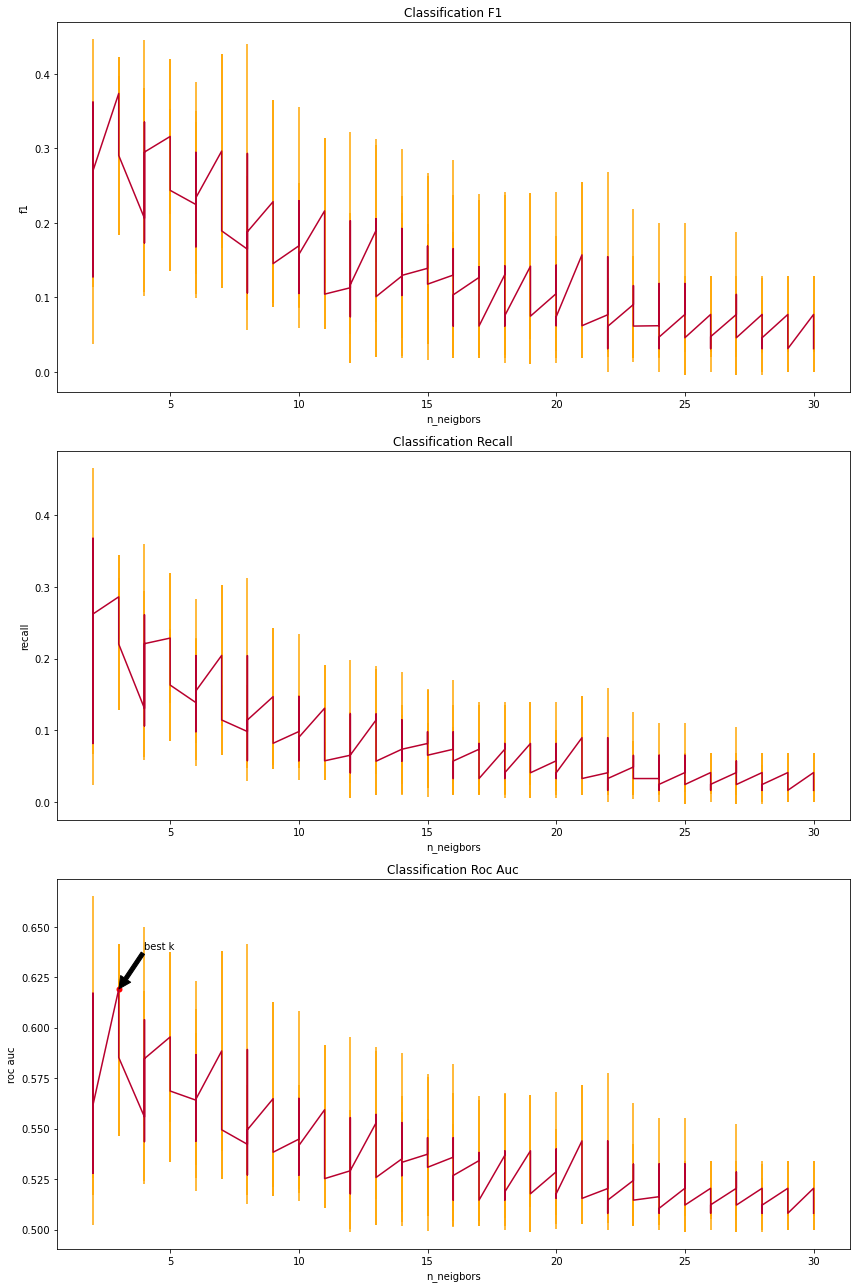



Permutation importances of the training set

OverTime                                           0.018794
StockOptionLevel                                   0.007873
EnvironmentSatisfaction                            0.006288
YearsAtCompany                                     0.005585
Age                                                0.003491
YearsInCurrentRole                                 0.002193
MonthlyHours                                       0.001816
PercentSalaryHike                                  0.001764
RelationshipSatisfaction                           0.001577
TrainingTimesLastYear                              0.000947
DistanceFromHome                                   0.000392
TaxRate                                            0.000044
JobRole                                            -0.000305
JobSatisfaction                                    -0.000484
NumCompaniesWorked                                 -0.000941
MonthlyIncome                                     

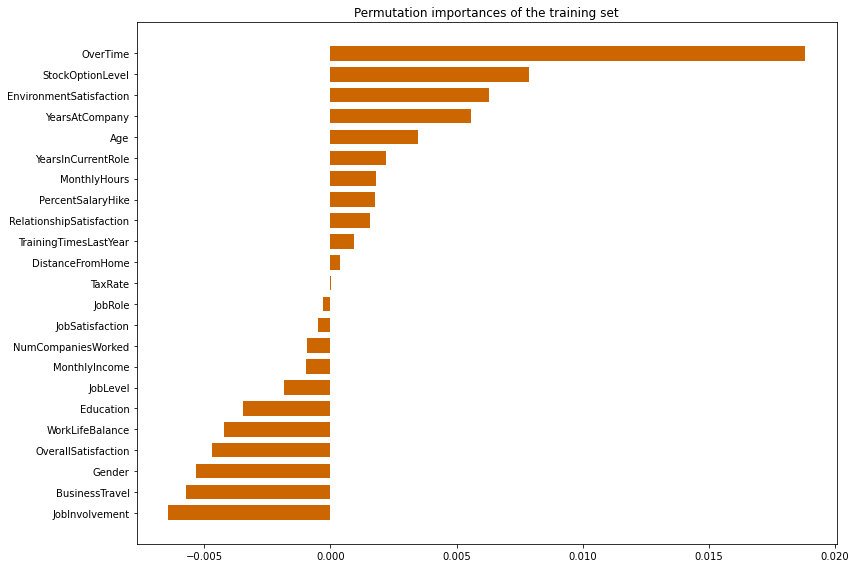



Predictions

Permutation importances of the test set

JobSatisfaction                                    0.061003
BusinessTravel                                     0.022061
MonthlyIncome                                      0.019289
OverTime                                           0.014295
YearsAtCompany                                     0.014129
JobInvolvement                                     0.013235
StockOptionLevel                                   0.013135
NumCompaniesWorked                                 0.003800
YearsInCurrentRole                                 0.001569
TaxRate                                            -0.000420
Age                                                -0.005590
TrainingTimesLastYear                              -0.005822
WorkLifeBalance                                    -0.009545
DistanceFromHome                                   -0.013235
JobLevel                                           -0.016273
OverallSatisfaction                   

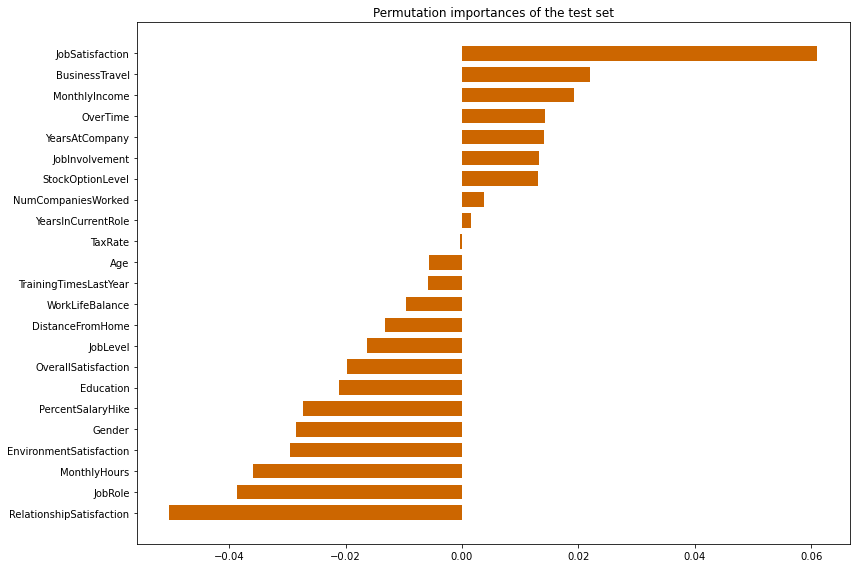



Confusion matrix


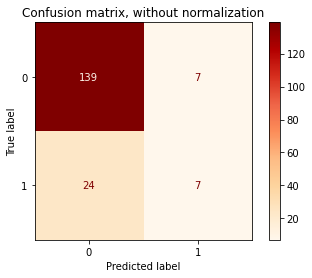

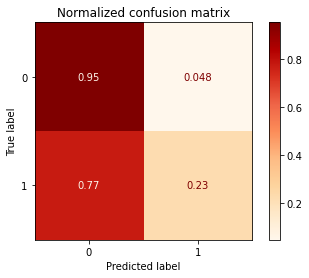


Classification report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       146
           1       0.50      0.23      0.31        31

    accuracy                           0.82       177
   macro avg       0.68      0.59      0.61       177
weighted avg       0.79      0.82      0.80       177


Metrics

Accuracy 0.8248587570621468
F1-score [0.89967638 0.31111111]
Precision [0.85276074 0.5       ]
Recall [0.95205479 0.22580645]
Roc_auc 0.5889306230667256


Roc curve



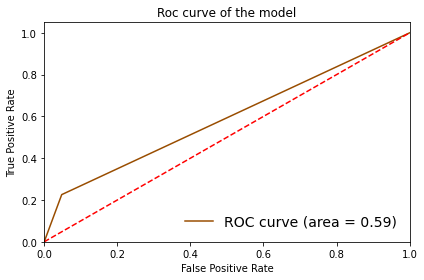


-------------------------------------------------------------------------------------------------------------



In [17]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [18]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.10921501706484642, 1.0],
   'tpr': [0.0, 0.22950819672131148, 1.0],
   'roc': 0.5601465898282325},
  '70-30': {'fpr': [0.0, 0.0958904109589041, 1.0],
   'tpr': [0.0, 0.2608695652173913, 1.0],
   'roc': 0.5824895771292437},
  '80-20': {'fpr': [0.0, 0.07534246575342465, 1.0],
   'tpr': [0.0, 0.25806451612903225, 1.0],
   'roc': 0.5913610251878038}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.12627986348122866, 1.0],
   'tpr': [0.0, 0.2786885245901639, 1.0],
   'roc': 0.5762043305544676},
  '70-30': {'fpr': [0.0, 0.1324200913242009, 1.0],
   'tpr': [0.0, 0.34782608695652173, 1.0],
   'roc': 0.6077029978161604},
  '80-20': {'fpr': [0.0, 0.0821917808219178, 1.0],
   'tpr': [0.0, 0.16129032258064516, 1.0],
   'roc': 0.5395492708793638}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.051194539249146756, 1.0],
   'tpr': [0.0, 0.16393442622950818, 1.0],
   'roc': 0.5563699434901808},
  '70-30': {'fpr': [0.0, 0.0319634703196347, 1.0],
   'tpr': [0.0, 0.239

In [23]:
temporal_info = {}

In [24]:
model_name = '24f numerical-encoded no discretized'

In [25]:
temporal_info[model_name] = scaler_dict['MaxAbsScaler']['70-30']
temporal_info

{'24f numerical-encoded no discretized': {'fpr': [0.0,
   0.1324200913242009,
   1.0],
  'tpr': [0.0, 0.34782608695652173, 1.0],
  'roc': 0.6077029978161604}}

In [26]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['no_discr']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)